In [2]:
import cmath
import numpy as np
from scipy.integrate import quad
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft
import warnings
warnings.filterwarnings("ignore")

In [3]:
def f(x):
    return np.sin(2 * x) + 6j + np.cos(x) 
    
def integrand(x,w=1):
    return f(x) * np.exp(1j * w * x)

# Integrals

### Theoretical Explanation:


1. **Simpson's Rule**:
   Simpson's rule is a numerical method used to approximate the definite integral of a function. It's based on approximating the area under the curve by using quadratic interpolating polynomials. The general formula for Simpson's rule is:
   $$ \int_a^b f(x) \,dx \approx \frac{h}{3} \left[ f(x_0) + 4f(x_1) + 2f(x_2) + \ldots + 4f(x_{n-1}) + f(x_n) \right] $$
   where \( h \) is the step size, and \( x_i \) are the points of evaluation within the interval \([a, ]\).

<img src="sims.gif" alt="Simpson's Rule">

### Code:

In [4]:
def integrate_simpson(integrand, a, b, n=10000,w=1):
    h = (b - a) / n # Calculate the step size
    sum_complex = 0
    for i in range(n + 1):     # Summation using Simpson's rule
        x = a + i * h
        coefficient = 1 if i == 0 or i == n else (2 if i % 2 == 0 else 4)
        sum_complex += coefficient * integrand(x,w)
    return h * sum_complex / 3

In [5]:
def complex_to_polar(z):
    r = np.abs(z)
    theta = cmath.phase(z)
    return r, theta

### Checks:

#### My integral code check:

In [6]:
# a= 7
# b = 9
a = float(input("Enter your lower bound: "))
b = float(input("Enter your upper bound: "))
w = float(input("Enter freq controller (w): "))

Enter your lower bound:  3
Enter your upper bound:  7
Enter freq controller (w):  3


In [7]:
res = integrate_simpson(integrand, a, b, 1000,3)
print("Complex:", res)
print("Polar:", complex_to_polar(res))

Complex: (2.0315903599196936+1.6465203984057313j)
Polar: (2.615031321587716, 0.6810858368009104)


#### Built-in check

In [8]:
result_real, _ = quad(lambda x: integrand(x,3).real, a, b)
result_imag, _ = quad(lambda x: integrand(x,3).imag, a, b)
result = result_real + 1j * result_imag
print("built-in complex:", result)
print("polar:", cmath.polar(result))

built-in complex: (2.0315903597779528+1.6465203981247822j)
polar: (2.6150313213007035, 0.6810858367515722)


# Fourier

### Theoretical explanation:

The trigonometric Fourier series for a periodic function $f(x)$ with period $T$ is given by:

$$
f(x) = \frac{a_0}{2} + \sum_{k=1}^{\infty} \left( a_k \cos\left(\frac{2\pi k x}{T}\right) + b_k \sin\left(\frac{2\pi k x}{T}\right) \right)
$$

Where:
- $a_0$ is the DC (average) component and is calculated as $a_0 = \frac{1}{T} \int_{0}^{T} f(x) \, dx$
- $a_k$ and $b_k$ are the Fourier coefficients and are calculated as $a_k = \frac{2}{T} \int_{0}^{T} f(x) \cos\left(\frac{2\pi k x}{T}\right) \, dx$ and $b_k = \frac{2}{T} \int_{0}^{T} f(x) \sin\left(\frac{2\pi k x}{T}\right) \, dx$ for  k > 0 \).

<img src="fourier.gif" alt="Simpson's Rule">

### Code:

In [9]:
def Sf(x, periodic_time, no_of_terms=30,accuracy=10000,w=1):
    def a0(integrand, periodic_time, accuracy,w=w):
        return integrate_simpson(integrand, 0, periodic_time, accuracy,w) / periodic_time

    def ak(integrand, k, periodic_time, accuracy,w=w):
        def integrand_fn(x,w=w):
            return integrand(x,w) * np.cos(2 * np.pi * k * x / periodic_time)
        return (2 / periodic_time) * integrate_simpson(integrand_fn, 0, periodic_time, accuracy,w) 

    def bk(integrand, k, periodic_time, accuracy,w=w):
        def integrand_fn(x,w=w):
            return integrand(x,w) * np.sin(2 * np.pi * k * x / periodic_time)
        return (2 / periodic_time) * integrate_simpson(integrand_fn, 0, periodic_time, accuracy,w)

    a0_value = a0(integrand, periodic_time, accuracy,w)
    sum_terms = np.zeros_like(x, dtype=np.complex128)
    for i in range(1, no_of_terms + 1):
        sum_terms += ak(integrand, i, periodic_time, accuracy,w) * np.cos(2 * np.pi * i * x / periodic_time) + \
                     bk(integrand, i, periodic_time, accuracy,w) * np.sin(2 * np.pi * i * x / periodic_time)
    sum_terms += a0_value
    return sum_terms

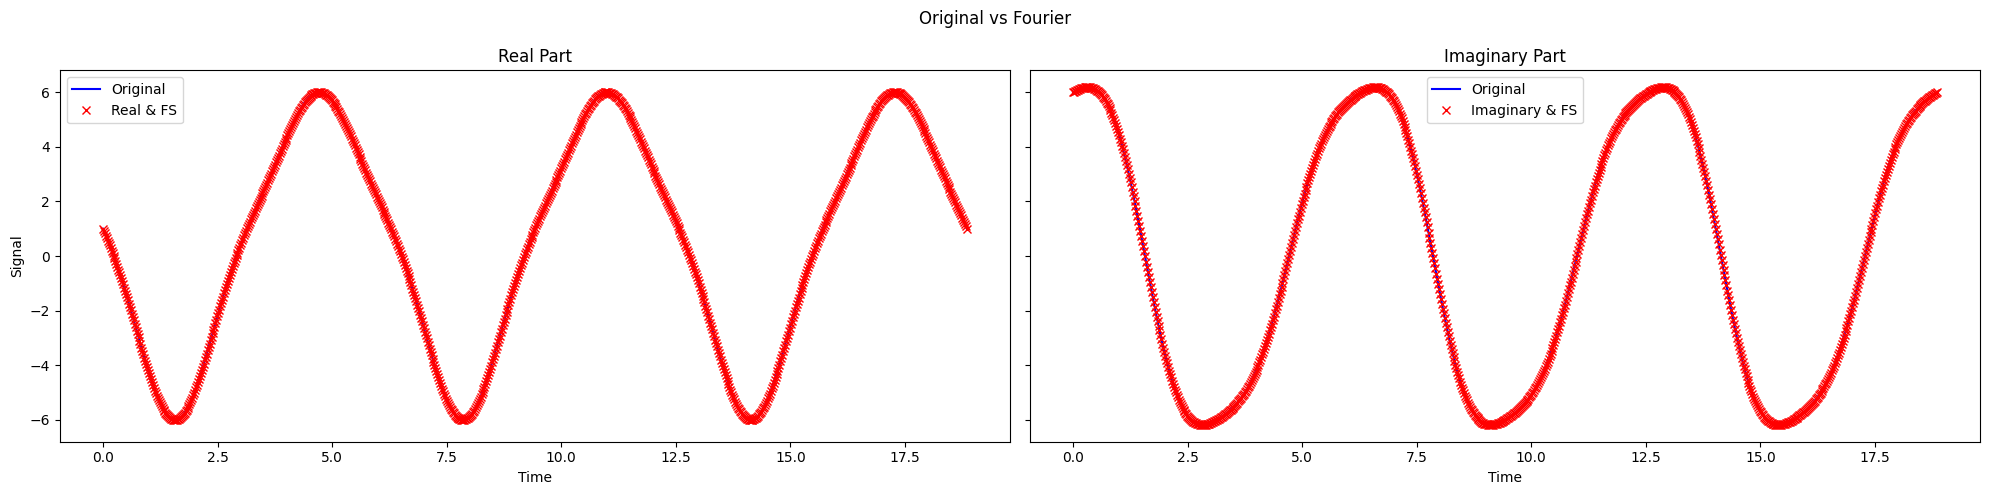

In [10]:
x = np.linspace(0, 2*3 * np.pi, 900)
T =  2 * np.pi
fs = Sf(x, T)

# Plot original and Fourier signals
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5), sharey=True)
ax1.plot(x, np.real(integrand(x)), color='blue', label='Original')
ax2.plot(x, np.imag(integrand(x)), color='blue', label='Original')
ax1.plot(x, np.real(fs), 'x', color='red', label='Real & FS', linewidth=0.2)
ax2.plot(x, np.imag(fs), 'x', color='red', label='Imaginary & FS', linewidth=0.2)

ax1.set_xlabel('Time')
ax2.set_xlabel('Time')
ax1.set_ylabel('Signal')
ax1.set_title('Real Part')
ax2.set_title('Imaginary Part')
ax1.legend(), ax2.legend()

plt.suptitle('Original vs Fourier')
plt.tight_layout()
plt.show()

In [15]:
fs

array([0.82948312-0.00671637j, 0.86194619+0.00342734j,
       0.90682308+0.01759588j, ..., 0.83860269-0.01987827j,
       0.81980547-0.01371784j, 0.82948312-0.00671637j])

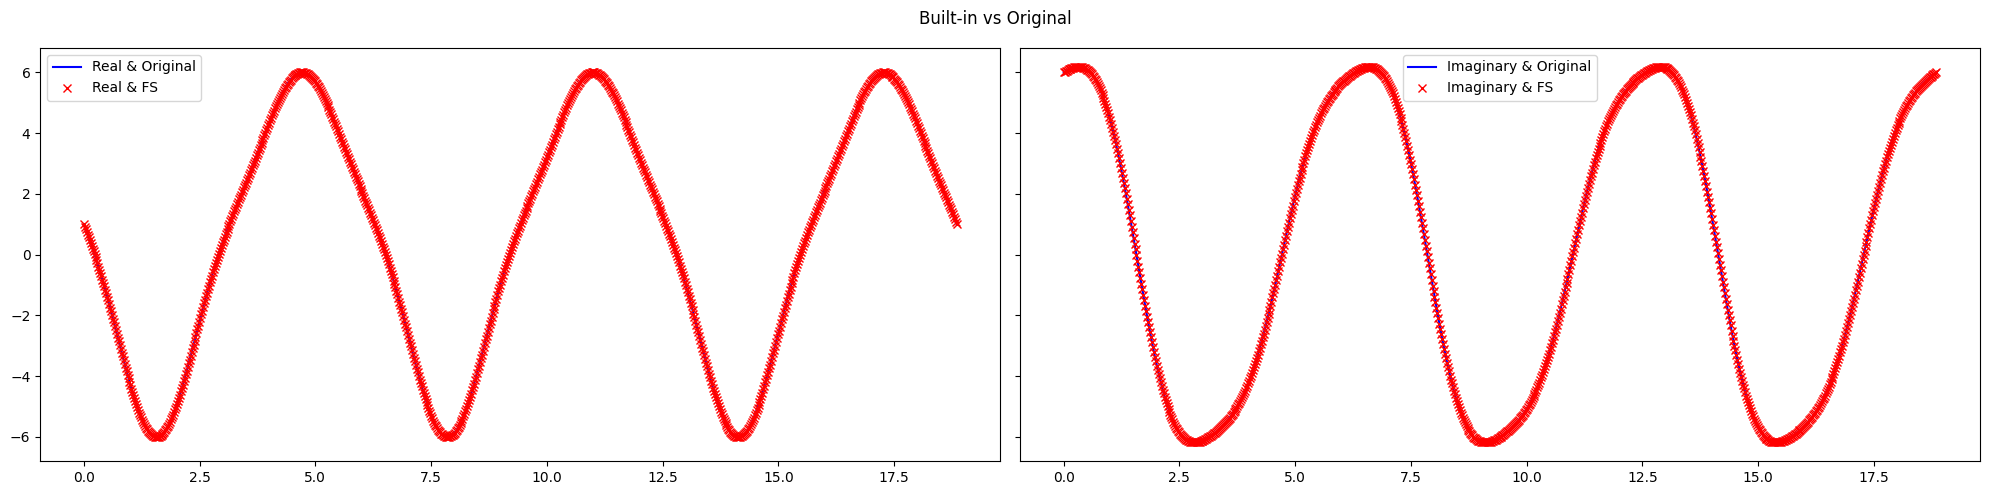

In [11]:
x = np.linspace(0, 2*3* np.pi, 900)

# Compute the Fourier coefficients using FFT
fourier_coeffs = fft(integrand(x))
reconstructed_signal = ifft(fourier_coeffs)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5), sharey=True)
# Plot original, Fourier signals
ax1.plot(x, np.real(integrand(x)), color='blue', label='Real & Original')
ax1.plot(x, np.real(reconstructed_signal), 'x', color='red', label='Real & FS')
ax1.legend()

ax2.plot(x, np.imag(integrand(x)), color='blue', label='Imaginary & Original')
ax2.plot(x, np.imag(reconstructed_signal), 'x', color='red', label='Imaginary & FS')
ax2.legend()

plt.suptitle('Built-in vs Original')
plt.tight_layout()
plt.show()

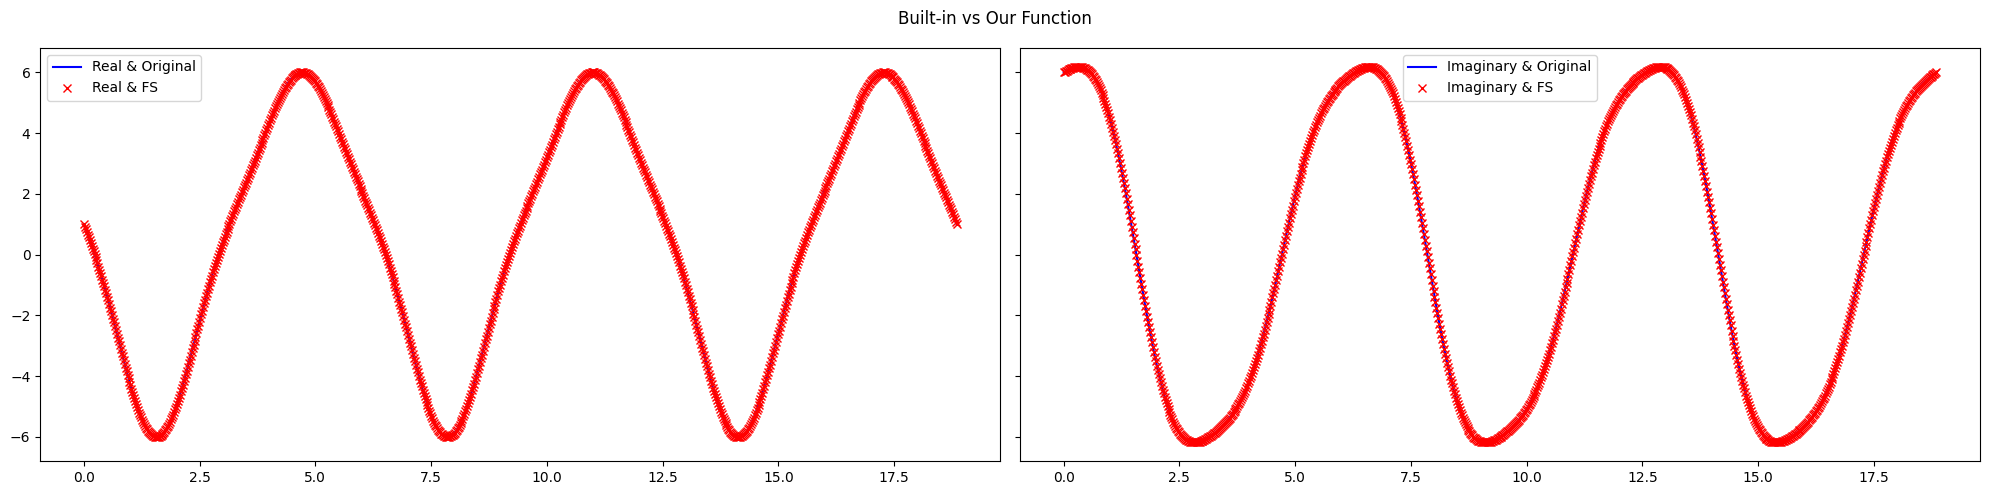

In [12]:
x = np.linspace(0, 2 * 3 * np.pi, 900)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5), sharey=True)
# Plot original, Fourier signals
ax1.plot(x, np.real(fs), color='blue', label='Real & Original')
ax1.plot(x, np.real(reconstructed_signal), 'x', color='red', label='Real & FS')
ax1.legend()

ax2.plot(x, np.imag(fs), color='blue', label='Imaginary & Original')
ax2.plot(x, np.imag(reconstructed_signal), 'x', color='red', label='Imaginary & FS')
ax2.legend()

plt.suptitle('Built-in vs Our Function')
plt.tight_layout()
plt.show()

### Some testing (For fun)

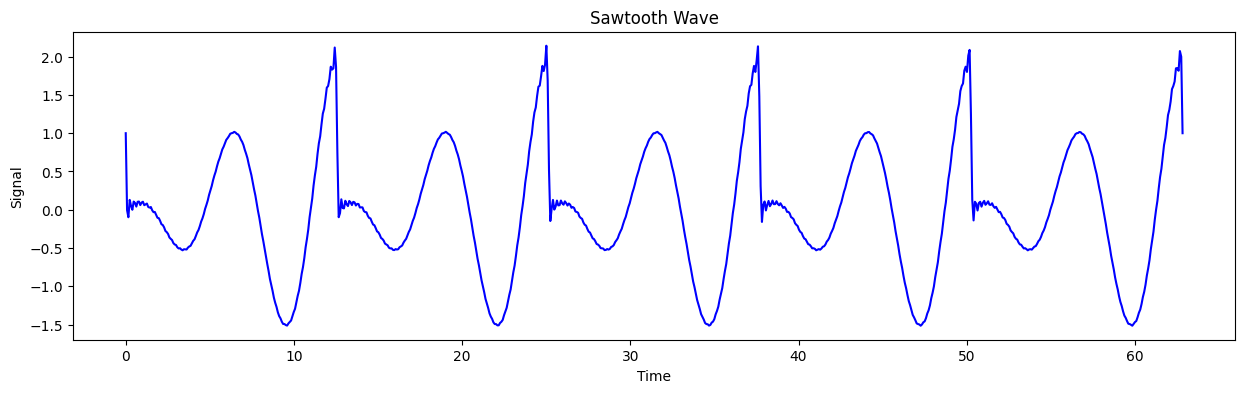

In [13]:
def f(x):  # Sawtooth wave function
    return x / (2*np.pi)

x = np.linspace(0, 4*5 *np.pi, 800)
T = 4*np.pi

fs = Sf(x, T, no_of_terms=50)
plt.figure(figsize=(15,4))
plt.plot(x, np.real(fs), color='blue')
plt.xlabel('Time')
plt.ylabel('Signal')
plt.title('Sawtooth Wave')
plt.show()

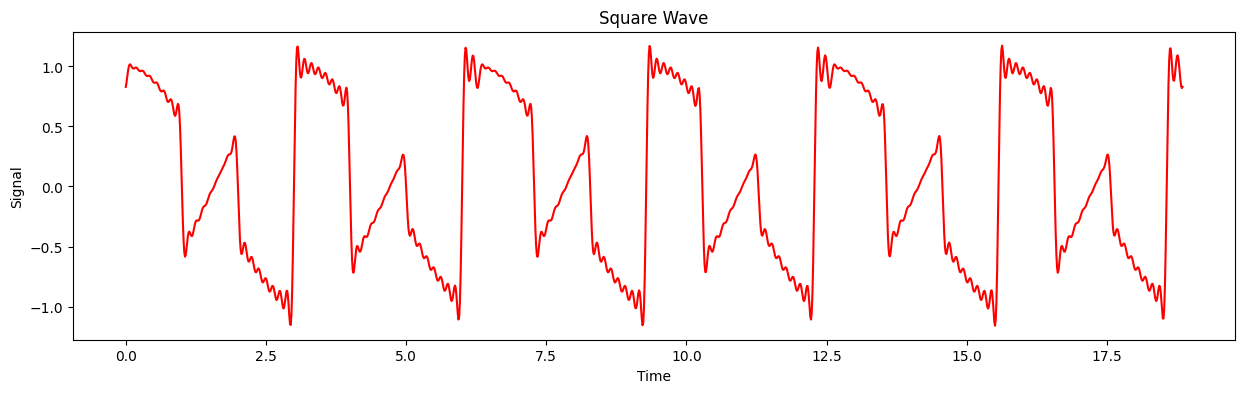

In [14]:
def f(x):
    n_terms = 10
    result = 0
    for n in range(1, n_terms + 1):
        result += (1 / (2 * n - 1)) * np.sin((2 * n - 1) * np.pi * x)
    return (4 / np.pi) * result

x = np.linspace(0, 2*3 *np.pi, 1500)  
T = 2*np.pi

fs = Sf(x, T, no_of_terms=50)

plt.figure(figsize=(15,4))
plt.plot(x, fs, color='red') 
plt.xlabel('Time')
plt.ylabel('Signal')
plt.title('Square Wave')
plt.show()